# DATA PREPARATION

In [193]:
# Import the libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [194]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
# Dataset (sources: https://www.kaggle.com/carrie1/ecommerce-data; Information: https://archive.ics.uci.edu/ml/datasets/online+retail)
DATA = '/content/drive/MyDrive/VEF_UK_Project/UK E-Commerce Raw Data.csv'

df = pd.read_csv(DATA, encoding='ISO-8859-1')

In [196]:
#DATAtb = '/content/drive/MyDrive/VEF_UK_Project/OutputUK.csv'
#df_tb = pd.read_csv(DATAtb, encoding='ISO-8859-1')

In [197]:
numerical_columns = df.drop(columns='UnitPrice').select_dtypes('number').columns
print(numerical_columns)

Index(['Quantity', 'CustomerID'], dtype='object')


In [198]:
non_numerical_columns = df.select_dtypes(['category', 'object']).columns
print(non_numerical_columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country'], dtype='object')


In [199]:
#def prepare_data(df):
    #df = pd.read_csv(DATA, encoding='ISO-8859-1')
    #df = df.drop(columns='CustomerID')
    #numerical_columns = df.drop(columns='UnitPrice').select_dtypes('number').columns
    #non_numerical_columns = df.select_dtypes(['category', 'object']).columns
    #return df

In [200]:
### Note

# Save dataframe to csv
#cleaned_df.to_csv('link/new_name.csv')

# Convert dataframe columns of object type to float
#cols = df.select_dtypes(exclude=['float']).columns
#df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
#df.info()

# DATA DISCOVERY

In [201]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [202]:
# Data shape/dimension
df.shape

(541909, 8)

In [203]:
# Data type & memory
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [204]:
# Basic statistics
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [205]:
# Summary of the numeric and object columns
print(df.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]))
df.describe(include=[np.object])

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
1%         -2.000000       0.190000   12415.000000
5%          1.000000       0.420000   12626.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
95%        29.000000       9.950000   17905.000000
99%       100.000000      18.000000   18212.000000
max     80995.000000   38970.000000   18287.000000


,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [206]:
# Total number of values in the column
df.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [207]:
# Count the negative value of of quantity and Unit Price
print('The number of rows with negative Quantity:',sum(n < 0 for n in df.Quantity))
print('The number of rows with negative UnitPrice:',sum(n < 0 for n in df.UnitPrice))

The number of rows with negative Quantity: 10624
The number of rows with negative UnitPrice: 2


In [208]:
# Negative UnitPrice

negative_unitprice = df[df.UnitPrice < 0]
negative_unitprice

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [209]:
# Negative Quantity
negative_quantity = df[df.Quantity < 0]
negative_quantity

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [210]:
# Minimum values in UnitPrice and Quantity
print('Minimum Quantity: ', df.Quantity.min())
print('Minimum Unit Price: ', df.UnitPrice.min())

Minimum Quantity:  -80995
Minimum Unit Price:  -11062.06


In [211]:
# Check StockcCode Bank
df[df['StockCode'].str.startswith('B')] # D, M, P

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4406,536779,BANK CHARGES,Bank Charges,1,12/2/2010 15:08,15.000,15823.0,United Kingdom
14435,C537572,BANK CHARGES,Bank Charges,-1,12/7/2010 12:00,95.380,NaN,United Kingdom
28992,C538680,BANK CHARGES,Bank Charges,-1,12/13/2010 17:10,966.920,NaN,United Kingdom
62508,541505,BANK CHARGES,Bank Charges,1,1/18/2011 15:58,15.000,15939.0,United Kingdom
64573,C541653,BANK CHARGES,Bank Charges,-1,1/20/2011 11:50,1050.150,NaN,United Kingdom
90558,C544049,BANK CHARGES,Bank Charges,-1,2/15/2011 12:39,566.370,NaN,United Kingdom
96675,C544575,BANK CHARGES,Bank Charges,-1,2/21/2011 13:58,134.760,NaN,United Kingdom
96676,C544576,BANK CHARGES,Bank Charges,-1,2/21/2011 14:01,149.160,NaN,United Kingdom
96715,C544584,BANK CHARGES,Bank Charges,-1,2/21/2011 14:52,109.840,NaN,United Kingdom
112233,C545887,BANK CHARGES,Bank Charges,-1,3/7/2011 15:54,326.680,NaN,United Kingdom


In [212]:
# Count Unique value in all dataset columns
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [213]:
# Number of duplicate rows
sum(df.duplicated())

5268

In [214]:
duplicate = df[df.duplicated()]
duplicate

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [215]:
df._get_numeric_data().std().round(2)

Quantity       218.08
UnitPrice       96.76
CustomerID    1713.60
dtype: float64

In [216]:
#def calc_descriptive_statistics(df):
    #output = dict()
    #output['count'] = df.count()
    #output['count_distinct'] = df.nunique()
    #output['mean'] = df.mean(axis=1, skipna=True)
    #output['median'] = df.median()
    #output['min'] = df._get_numeric_data().min()
    #output['max'] = df._get_numeric_data().max()
    #output['std'] = df._get_numeric_data().std().round(2)
    #output['n_missing'] = pd.isnull(df).sum()
    #return output

#### Skewness

In [217]:
from scipy.stats import skew
import pylab as p

In [218]:
# skewness along the index axis
df.skew(axis = 0, skipna = True)

Quantity       -0.264076
UnitPrice     186.506972
CustomerID      0.029835
dtype: float64

In [219]:
#Use skew() function to find the skewness of the data over the column axis

# skip the na values
# find skewness in each row
df.skew(axis = 1, skipna = True)

0         1.732051
1         1.732051
2         1.732050
3         1.732051
4         1.732051
            ...   
541904    1.732046
541905    1.732050
541906    1.732051
541907    1.732051
541908    1.732051
Length: 541909, dtype: float64

Skewness for data :  1.1108237139164436


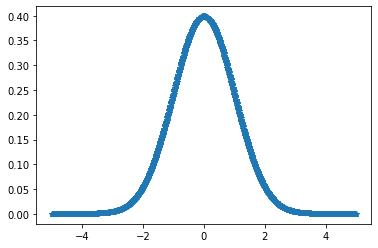

In [220]:
# Graph using numpy.linspace()
# Finding Skewness

x1 = np.linspace( -5, 5, 1000 )
y1 = 1./(np.sqrt(2.*np.pi)) * np.exp( -.5*(x1)**2  )

p.plot(x1, y1, '*')

print( 'Skewness for data : ', skew(y1))

Skewness for data :  1.917677776148478


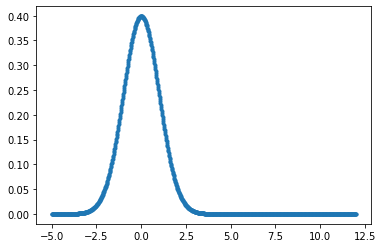

In [221]:
# Graph using numpy.linspace()
# Finding Skewness

x1 = np.linspace( -5, 12, 1000 )
y1 = 1./(np.sqrt(2.*np.pi)) * np.exp( -.5*(x1)**2  )

p.plot(x1, y1, '.')

print('Skewness for data : ', skew(y1))

In [222]:
# Finding Skewness
# Random values based on a normal distribution

x = np.random.normal(0, 2, 10000)

print ('X : ', x)

print('Skewness for data : ', skew(x))

X :  [-2.32466853  0.04980715 -0.54076792 ...  0.848754    1.69169816
 -3.31075032]
Skewness for data :  -0.015760287478390988


# DATA CLEANING
- Missing values
- Outliers

## Missing Values

In [223]:
# Check missing values
pd.isnull(df).sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [224]:
# Check rows with missing values
df[df.isnull().any(axis=1)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [225]:
# Missing Percentage of Data
df_percent = df.isnull().sum()/(len(df))*100
missing_data = pd.DataFrame({'Missing Rate':df_percent})
missing_data

,Missing Rate
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


In [226]:
# Show Null Description
df[df.Description.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [227]:
# Show Null CustomerID
df_nan_id = df[df.CustomerID.isnull()]
df_nan_id

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [228]:
df_nan_id.to_csv('/content/drive/MyDrive/VEF_UK_Project/nan_customer.csv')

### Customer with missing values

In [229]:
df_r = df.copy()
df_r["AmountSpent"] = df_r["Quantity"]*df_r["UnitPrice"]

In [230]:
# Assume Missing CustomerID is not registered customer = Random CustomerID, which contains "R" in ID
df_r["CustomerID"].fillna("R"+df_r["InvoiceNo"], inplace=True)

In [231]:
# Assign value to our missing customerID based on the Invoice Number
df_r.CustomerID.value_counts(sort=True)
new_id = df_r.groupby(['CustomerID','Description']).sum()
new_id.head(10)

Quantity  UnitPrice  AmountSpent
CustomerID Description                                                        
12346.0    MEDIUM CERAMIC TOP STORAGE JAR            0       2.08          0.0
12347.0    3D DOG PICTURE PLAYING CARDS            126      14.75        371.7
           3D SHEET OF CAT STICKERS                 12       0.85         10.2
           3D SHEET OF DOG STICKERS                 12       0.85         10.2
           60 TEATIME FAIRY CAKE CASES              72       1.65         39.6
           72 SWEETHEART FAIRY CAKE CASES           72       1.65         39.6
           AIRLINE BAG VINTAGE JET SET BROWN        28      25.50        119.0
           AIRLINE BAG VINTAGE JET SET RED          16      12.75         68.0
           AIRLINE BAG VINTAGE JET SET WHITE        12      12.75         51.0
           AIRLINE BAG VINTAGE TOKYO 78             32      16.70        132.4

In [232]:
# Check new customer ID
df_r[df_r['CustomerID'].str.contains("R",case=False, na=False)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,AmountSpent
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,R536414,United Kingdom,0.00
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,R536544,United Kingdom,2.51
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,R536544,United Kingdom,5.02
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,R536544,United Kingdom,3.40
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,R536544,United Kingdom,3.32


In [233]:
df_r.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      8082
Country           38
AmountSpent     6204
dtype: int64

In [234]:
# Add month
df_re = df_r[~df_r['CustomerID'].str.contains("R",case=False, na=False)]

df_re.InvoiceDate = pd.to_datetime(df_re.InvoiceDate, format='%m/%d/%Y %H:%M')
df_re = df_re.groupby([pd.Grouper(key='InvoiceDate', freq='M'),"CustomerID"])['AmountSpent'].sum().reset_index().sort_values('InvoiceDate')
df_re["Month"] = pd.DatetimeIndex(df_re["InvoiceDate"]).month

df_re.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,InvoiceDate,CustomerID,AmountSpent,Month
0,2010-12-31,12347.0,711.79,12
625,2010-12-31,16525.0,802.44,12
626,2010-12-31,16531.0,92.82,12
627,2010-12-31,16539.0,747.25,12
628,2010-12-31,16546.0,-583.68,12


In [235]:
df_re.nunique()

InvoiceDate       13
CustomerID      4372
AmountSpent    12745
Month             12
dtype: int64

In [236]:
# Revenue of each month
df_rema = df_re.groupby("Month")["AmountSpent"].sum().reset_index().sort_values('AmountSpent',ascending=False)
df_rema

,Month,AmountSpent
10,11,1132407.740
9,10,974603.590
8,9,931440.372
11,12,897110.400
4,5,648251.080
7,8,616368.000
5,6,608013.160
2,3,579964.610
6,7,574238.481
0,1,475074.380


In [237]:
# Find repeating monthly purchase customer
# Occurance colum will show how many time in a year that a unique customer purchase is
df_re["Occurance"] = df_re.groupby("CustomerID")["InvoiceDate"].transform(pd.Series.value_counts)
df_re.head()

,InvoiceDate,CustomerID,AmountSpent,Month,Occurance
0,2010-12-31,12347.0,711.79,12,1
625,2010-12-31,16525.0,802.44,12,1
626,2010-12-31,16531.0,92.82,12,1
627,2010-12-31,16539.0,747.25,12,1
628,2010-12-31,16546.0,-583.68,12,1


In [238]:
# Frequency of occurance based on monhly historical purchase for each customer ID 
df_rom = df_re.groupby("CustomerID")["Occurance"].count().reset_index().sort_values('Occurance',ascending=False)
df_rom.groupby("Occurance").count().reset_index().sort_values('Occurance',ascending=False)

,Occurance,CustomerID
12,13,48
11,12,41
10,11,55
9,10,61
8,9,81
7,8,95
6,7,107
5,6,182
4,5,283
3,4,388


### Remove missing values

In [239]:
# Check cancellation invoice
df_cancel = df[df['InvoiceNo'].str.startswith('C')]
df_cancel.head()
# invoices cancelled have the letter C in front of the 6 digit InvoiceNo

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [240]:
# Order cancellation percentage
order = df['InvoiceNo'].count()
order_cancel = df_cancel['InvoiceNo'].count()

print('Total orders:', order)
print('Total orders cancelled:', order_cancel)

n1 = order_cancel.sum()
n2 = order.sum()
percent = (n1/n2)*100

print('Order cancellation percentage:', percent,'%')

Total orders: 541909
Total orders cancelled: 9288
Order cancellation percentage: 1.7139409015166756 %


In [241]:
# Remove cancellation invoice
df = df.drop(df[df['InvoiceNo'].str.startswith('C')].index)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [242]:
# Change String to Int
#df['CustomerID'] = df['CustomerID'].astype('int64')

In [243]:
# Remove Null CustomerID
df = df[df['CustomerID'].notnull()]

In [244]:
# Remove Quantity with negative values
df = df[df.Quantity > 0]

In [245]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [246]:
# df without missing values
clear_na = df.dropna()

In [247]:
# Check missing values for each column
clear_na.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [248]:
clear_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  float64
 7   Country      397924 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


In [249]:
df = clear_na
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [250]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [251]:
print(df.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]))
df.describe(include=[np.object])

            Quantity      UnitPrice     CustomerID
count  397924.000000  397924.000000  397924.000000
mean       13.021823       3.116174   15294.315171
std       180.420210      22.096788    1713.169877
min         1.000000       0.000000   12346.000000
1%          1.000000       0.210000   12415.000000
5%          1.000000       0.420000   12627.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15159.000000
75%        12.000000       3.750000   16795.000000
95%        36.000000       8.500000   17912.000000
99%       120.000000      14.950000   18211.000000
max     80995.000000    8142.750000   18287.000000


,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,397924,397924,397924,397924,397924
unique,18536,3665,3877,17286,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,11/14/2011 15:27,United Kingdom
freq,542,2035,2028,542,354345


## Outliers

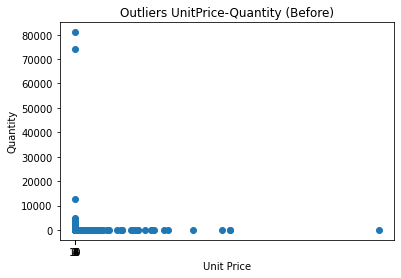

In [252]:
# Simple Outliers UnitPrice-Quantity (Before)
df_p_q = df[['UnitPrice', 'Quantity']].astype('float').sort_values(by='UnitPrice')
p = plt.scatter(x='UnitPrice', y='Quantity', data=df)
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.title('Outliers UnitPrice-Quantity (Before)')
p = plt.xticks(range(1, 11))

In [253]:
# Check UnitPrice Outliers
percentiles = [0.01, 0.05] + list(np.arange(0,1,0.1)) + [0.95, 0.99]
df.UnitPrice.describe(percentiles=percentiles)

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
0%            0.000000
1%            0.210000
5%            0.420000
10%           0.550000
20%           0.850000
30%           1.250000
40%           1.650000
50%           1.950000
60%           2.100000
70%           2.950000
80%           4.150000
90%           6.350000
95%           8.500000
99%          14.950000
max        8142.750000
Name: UnitPrice, dtype: float64

In [254]:
unit_price_q99 = df['UnitPrice'].quantile(0.99)
df_high_price = df[df['UnitPrice'] > unit_price_q99]

df_high_price.sort_values('UnitPrice', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,5/3/2011 13:46,8142.75,16029.0,United Kingdom
422351,573077,M,Manual,1,10/27/2011 14:13,4161.06,12536.0,France
422376,573080,M,Manual,1,10/27/2011 14:20,4161.06,12536.0,France
406406,571751,M,Manual,1,10/19/2011 11:18,3949.32,12744.0,Singapore
374542,569382,M,Manual,1,10/3/2011 16:44,3155.95,15502.0,United Kingdom
...,...,...,...,...,...,...,...,...
318928,564839,23444,Next Day Carriage,1,8/30/2011 12:45,15.00,13524.0,United Kingdom
39776,539676,POST,POSTAGE,3,12/21/2010 10:54,15.00,12423.0,Belgium
361461,568346,22781,GUMBALL MAGAZINE RACK,1,9/26/2011 15:28,14.96,14096.0,United Kingdom
527879,580727,22781,GUMBALL MAGAZINE RACK,2,12/5/2011 17:17,14.96,14096.0,United Kingdom


In [255]:
df_high_price.to_csv('/content/drive/MyDrive/VEF_UK_Project/high_price.csv')

In [256]:
df = df[df['UnitPrice'] <= unit_price_q99]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


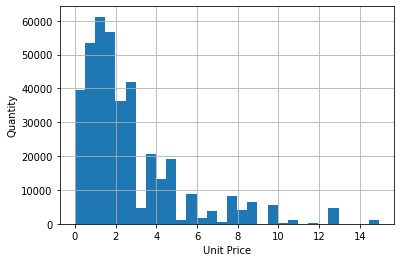

In [257]:
# Histogram UnitPrice
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
df.UnitPrice.hist(bins=30)

In [258]:
# Z score
z_price = zscore(df.UnitPrice)
z_price

array([-0.06412362,  0.26717503,  0.01475701, ...,  0.56692144,
        0.56692144,  0.88244396])

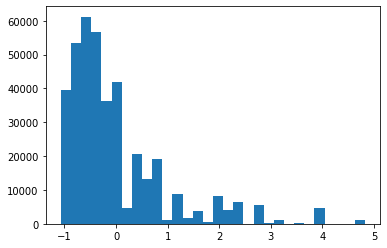

In [259]:
p = plt.hist(z_price, bins=30)

In [260]:
z_gt_2 = z_price > 2
df = df.drop(index=df[z_gt_2].index)

print('The number of outliers:', len(z_gt_2))

The number of outliers: 394190


In [261]:
z_gt_2

array([False, False, False, ..., False, False, False])

In [262]:
df.shape

(364061, 8)

In [263]:
# Check Quantity Outliers
percentiles = [0.01, 0.05] + list(np.arange(0,1,0.1)) + [0.95, 0.99]
df.Quantity.describe(percentiles=percentiles)

count    364061.000000
mean         13.959880
std         188.581399
min           1.000000
0%            1.000000
1%            1.000000
5%            1.000000
10%           1.000000
20%           2.000000
30%           3.000000
40%           4.000000
50%           6.000000
60%          10.000000
70%          12.000000
80%          12.000000
90%          24.000000
95%          48.000000
99%         144.000000
max       80995.000000
Name: Quantity, dtype: float64

In [264]:
quantity_q99 = df['Quantity'].quantile(0.99)
df_large_quantity= df[df['Quantity'] > quantity_q99]

df_large_quantity.sort_values('Quantity', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.00,13256.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.21,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.72,13135.0,United Kingdom
...,...,...,...,...,...,...,...,...
530559,580875,22422,TOOTHPASTE TUBE PEN,150,12/6/2011 12:11,0.12,17744.0,United Kingdom
218759,556066,84978,HANGING HEART JAR T-LIGHT HOLDER,150,6/8/2011 14:32,1.06,16872.0,United Kingdom
287970,562123,22662,LUNCH BAG DOLLY GIRL DESIGN,150,8/2/2011 17:19,1.45,17353.0,United Kingdom
476467,577021,23203,JUMBO BAG VINTAGE DOILY,150,11/17/2011 12:39,1.79,12931.0,United Kingdom


In [265]:
# Remove Large quantity of products
df = df[df['Quantity'] <= quantity_q99]

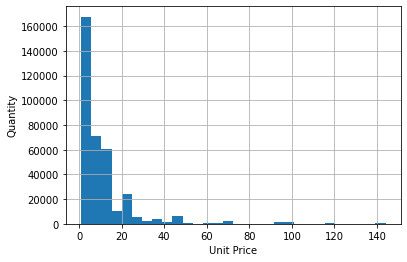

In [266]:
# Histogram Quantity
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
df.Quantity.hist(bins=30)

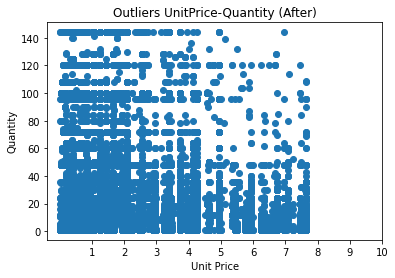

In [267]:
# Simple Outliers UnitPrice-Quantity (After)
df_p_q = df[['UnitPrice', 'Quantity']].astype('float').sort_values(by='UnitPrice')
p = plt.scatter(x='UnitPrice', y='Quantity', data=df)
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.title('Outliers UnitPrice-Quantity (After)')
p = plt.xticks(range(1, 11))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


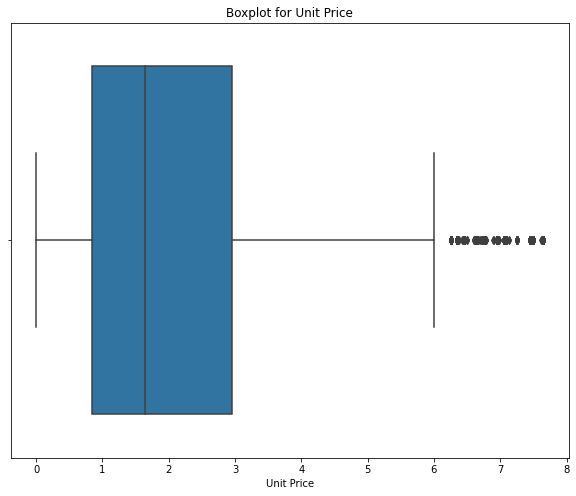

In [268]:
# Boxplot - Range
plt.subplots(figsize=(10,8))
sns.boxplot(df.UnitPrice)

plt.xlabel('Unit Price')
plt.title('Boxplot for Unit Price')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


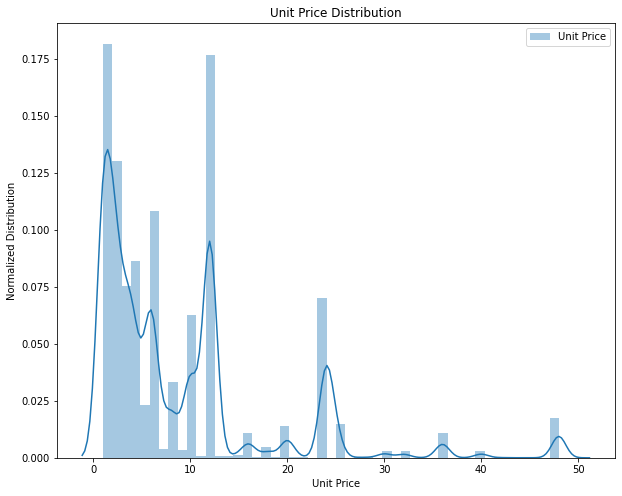

In [269]:
# Distribution plot
plt.subplots(figsize=(10,8))
sns.distplot(df.Quantity[df.Quantity < 50], label='Unit Price').legend()

plt.xlabel('Unit Price')
plt.ylabel('Normalized Distribution')
plt.title('Unit Price Distribution')
plt.show()

In [270]:
# Correlation coefficient
cor_matrix = df.corr()
df.corr()

,Quantity,UnitPrice,CustomerID
Quantity,1.000000,-0.236136,-0.087549
UnitPrice,-0.236136,1.000000,-0.003171
CustomerID,-0.087549,-0.003171,1.000000


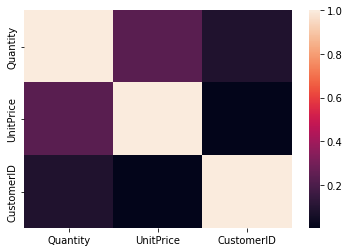

In [271]:
sns.heatmap(np.abs(cor_matrix))

numpy.ndarray

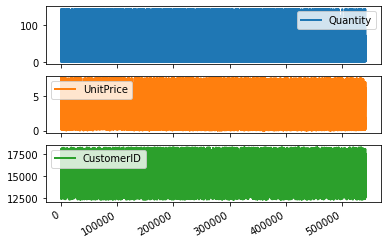

In [272]:
# Line Chart for numeric data
axes = df.plot.line(subplots=True,linewidth=2)
type(axes)

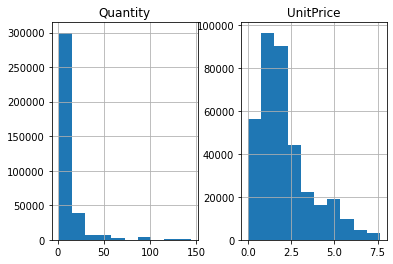

In [273]:
# Histogram for numeric data
df_num = pd.DataFrame(df, columns = ['InvoiceNo', 'Quantity', 'UnitPrice'])
df_num.hist()
plt.show()

# DATA ENRICHMENT
Format and Add more columns


In [274]:
# Remove duplicate rows from dataset
df = df.drop_duplicates()
# Reformatting columns
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')
df_cancel.InvoiceDate = pd.to_datetime(df_cancel.InvoiceDate, format='%m/%d/%Y %H:%M')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [275]:
# Add Year Column
df['Year'] = pd.DatetimeIndex(df['InvoiceDate']).year
df_cancel['Year'] = pd.DatetimeIndex(df_cancel['InvoiceDate']).year

# Add Month Column
df['Month'] = pd.DatetimeIndex(df['InvoiceDate']).month
df_cancel['Month'] = pd.DatetimeIndex(df_cancel['InvoiceDate']).month


# Add Year Month
df['YearMonth'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')
df_cancel['YearMonth'] = pd.to_datetime(df_cancel['InvoiceDate']).dt.to_period('M')

# Add Day of Week Column (Monday = 1 ... Sunday = 7)
df['DayWeek'] = (df.InvoiceDate.dt.dayofweek)+1
df_cancel['DayWeek'] = (df_cancel.InvoiceDate.dt.dayofweek)+1 

# Add Day of Month Column 
df['DayMonth'] = pd.DatetimeIndex(df['InvoiceDate']).day
df_cancel['DayMonth'] = pd.DatetimeIndex(df_cancel['InvoiceDate']).day

# Add Hour Column
df['Hour'] = pd.DatetimeIndex(df['InvoiceDate']).hour
df_cancel['Hour'] = pd.DatetimeIndex(df_cancel['InvoiceDate']).hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [276]:
# Modify day of week
#weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#day_name = dict(zip(range(1,8), weekdays))
#day_name

#df['DayWeek'] = df.InvoiceDate.dt.dayofweek.map(day_name)

In [277]:
# Add Seasons
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
#seasons = ['Winter', 'Winter', 'Spring' , 'Spring' , 'Spring', 'Summer', 'Summer', 'Summer', 'Autumn', 'Autumn', 'Autumn', 'Winter']

month_to_season = dict(zip(range(1,13), seasons))
#month_to_season

df['Season'] = df.InvoiceDate.dt.month.map(month_to_season)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [278]:
# Add Amount Spent
df['AmountSpent'] = df['Quantity'] * df['UnitPrice']
df_cancel['AmountSpent'] = df_cancel['Quantity'] * df_cancel['UnitPrice']
df_nan_id['AmountSpent'] = df_nan_id['Quantity'] * df_nan_id['UnitPrice']
df_high_price['AmountSpent'] = df_high_price['Quantity'] * df_high_price['UnitPrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [279]:
# Add Range of UnitPrice
df['PriceRange'] = pd.cut(df['UnitPrice'], [0, 2, 4, 6, 8], labels=['0-2', '2-4', '4-6', '6-8'])
df_pr = df.groupby('PriceRange')['AmountSpent'].sum().reset_index().sort_values('AmountSpent', ascending=False).round()
df_pr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PriceRange,AmountSpent
0,0-2,2890822.0
1,2-4,2053027.0
2,4-6,1016793.0
3,6-8,295031.0


In [280]:
#visit = df.groupby(['CustomerID', 'Month']).cumcount()+1
#df['Visit'] = visit.sum()

In [281]:
df = df[['InvoiceNo','StockCode','Description','Quantity','UnitPrice','PriceRange','AmountSpent','CustomerID','Country','InvoiceDate','Year','Month','YearMonth','Season','DayMonth','DayWeek','Hour']]

In [282]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,PriceRange,AmountSpent,CustomerID,Country,InvoiceDate,Year,Month,YearMonth,Season,DayMonth,DayWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,2-4,15.30,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8
1,536365,71053,WHITE METAL LANTERN,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,2-4,22.00,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8


In [283]:
df.to_csv('/content/drive/MyDrive/VEF_UK_Project/clean_df_n.csv')

In [284]:
df_cancel.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,YearMonth,DayWeek,DayMonth,Hour,AmountSpent
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010,12,2010-12,3,1,9,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010,12,2010-12,3,1,9,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,2010-12,3,1,10,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,2010-12,3,1,10,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,2010-12,3,1,10,-6.96


In [285]:
df_cancel.to_csv('/content/drive/MyDrive/VEF_UK_Project/cancel_order.csv')

# INSIGHTS & DATA VISUALIZATION
- Explore patterns for Customer
- Explore patterns for Country
- Explore patterns for Product
- Explore patterns for Time
- Explore patterns for Canceled orders


In [286]:
print('Total Orders: ', df['InvoiceNo'].count())
print('Total Revenue: ', df['AmountSpent'].sum().round())

Total Orders:  356428
Total Revenue:  6255673.0


In [287]:
print('Total Cancel Orders: ', df_cancel['InvoiceNo'].count()) # ~2.5% of Total
print('Total Lost Revenue: ', df_cancel['AmountSpent'].sum().round())
print('---')
print('Total Orders of non-login customer: ', df_nan_id['InvoiceNo'].count()) # ~27.5% of Total
print('Total Revenue of non-login customer: ', df_nan_id['AmountSpent'].sum().round())
print('---')
print('Total Orders of high unit price product: ', df_high_price['InvoiceNo'].count()) # ~1% of Total
print('Total Revenue of high unit price product: ', df_high_price['AmountSpent'].sum().round())

Total Cancel Orders:  9288
Total Lost Revenue:  -896812.0
---
Total Orders of non-login customer:  135080
Total Revenue of non-login customer:  1447682.0
---
Total Orders of high unit price product:  3734
Total Revenue of high unit price product:  300169.0


## Customer

### General analysis

In [288]:
# Number of orders made by customers
cus_order = df.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()
cus_order.head()

,CustomerID,Country,InvoiceNo
0,12347.0,Iceland,174
1,12348.0,Finland,27
2,12349.0,Italy,60
3,12350.0,Norway,16
4,12352.0,Norway,66


In [289]:
# Top 5 Customers with the most orders
cus_max_orders = df.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()
cus_max_orders.sort_values(by='InvoiceNo', ascending=False).head()

,CustomerID,Country,InvoiceNo
3967,17841.0,United Kingdom,7255
1869,14911.0,EIRE,4867
1283,14096.0,United Kingdom,4454
333,12748.0,United Kingdom,4167
1652,14606.0,United Kingdom,2442


In [290]:
# Customer's money spent
cus_spent = df.groupby(by=['CustomerID','Country'], as_index=False)['AmountSpent'].sum()
cus_spent.head()

,CustomerID,Country,AmountSpent
0,12347.0,Iceland,3731.55
1,12348.0,Finland,1437.24
2,12349.0,Italy,1089.15
3,12350.0,Norway,294.40
4,12352.0,Norway,1130.94


In [291]:
# Top 5 Customers with highest money spent
cus_spent.sort_values(by='AmountSpent', ascending=False).head()

,CustomerID,Country,AmountSpent
1679,14646.0,Netherlands,176570.00
1869,14911.0,EIRE,107925.43
3731,17511.0,United Kingdom,75354.86
56,12415.0,Australia,71348.44
4151,18102.0,United Kingdom,69965.19


In [292]:
# Average Customer spending
order_cus = df.groupby(by=['CustomerID'])['InvoiceNo'].count()
spent_cus = df.groupby(by=['CustomerID'])['AmountSpent'].sum()

cus_average = spent_cus/order_cus
cus_average.sort_values(ascending=False).head()

CustomerID
15299.0    584.925
17291.0    550.800
16716.0    450.600
15649.0    408.000
16041.0    405.800
dtype: float64

### RFM - Customer Segmentation

In [293]:
# First and last order dates
print('Date Start:' ,df['InvoiceDate'].min())
print('Date End:' ,df['InvoiceDate'].max())

Date Start: 2010-12-01 08:26:00
Date End: 2011-12-09 12:50:00


In [294]:
# Use 2011–12–10 to calculate recency
now = dt.datetime(2011,12,10)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [295]:
# Create RFM table
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days, 'InvoiceNo': lambda x: len(x), 'AmountSpent': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'AmountSpent': 'MonetaryValue'}, inplace=True)

rfmTable.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,2,174,3731.55
12348.0,75,27,1437.24
12349.0,18,60,1089.15
12350.0,310,16,294.40
12352.0,36,66,1130.94


In [296]:
# Split metrics
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [297]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [298]:
# Create segmented RFM table
segmented_rfm = rfmTable
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
segmented_rfm['M_quartile'] = segmented_rfm['MonetaryValue'].apply(FMScore, args=('MonetaryValue',quantiles,))

segmented_rfm.head()

,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile
CustomerID,,,,,,
12347.0,2,174,3731.55,1,1,1
12348.0,75,27,1437.24,3,3,1
12349.0,18,60,1089.15,2,2,2
12350.0,310,16,294.40,4,3,3
12352.0,36,66,1130.94,2,2,2


In [299]:
# Add RFM Score (best customers = 111)
segmented_rfm['RFMScore'] = segmented_rfm.R_quartile.map(str) + segmented_rfm.F_quartile.map(str) + segmented_rfm.M_quartile.map(str)

segmented_rfm.head()

,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFMScore
CustomerID,,,,,,,
12347.0,2,174,3731.55,1,1,1,111
12348.0,75,27,1437.24,3,3,1,331
12349.0,18,60,1089.15,2,2,2,222
12350.0,310,16,294.40,4,3,3,433
12352.0,36,66,1130.94,2,2,2,222


In [300]:
# Top 10 best customers
best_cus = segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('MonetaryValue', ascending=False)
best_cus.head(10)

,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFMScore
CustomerID,,,,,,,
14646.0,1,1677,176570.00,1,1,1,111
14911.0,1,4867,107925.43,1,1,1,111
17511.0,2,861,75354.86,1,1,1,111
18102.0,0,273,69965.19,1,1,1,111
14156.0,9,1157,67377.52,1,1,1,111
15311.0,0,2245,54903.31,1,1,1,111
13089.0,2,1666,48680.72,1,1,1,111
14298.0,8,1580,45418.46,1,1,1,111
13694.0,3,460,43487.95,1,1,1,111


In [301]:
check_cus = df[df['CustomerID']==14646.0]
check_cus

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,PriceRange,AmountSpent,CustomerID,Country,InvoiceDate,Year,Month,YearMonth,Season,DayMonth,DayWeek,Hour
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,0.29,0-2,3.48,14646.0,Netherlands,2010-12-20 10:09:00,2010,12,2010-12,1,20,1,10
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,0.29,0-2,3.48,14646.0,Netherlands,2010-12-20 10:09:00,2010,12,2010-12,1,20,1,10
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,4.95,4-6,9.90,14646.0,Netherlands,2010-12-20 10:09:00,2010,12,2010-12,1,20,1,10
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,1.95,0-2,1.95,14646.0,Netherlands,2010-12-20 10:09:00,2010,12,2010-12,1,20,1,10
37956,539491,22613,PACK OF 20 SPACEBOY NAPKINS,2,0.85,0-2,1.70,14646.0,Netherlands,2010-12-20 10:09:00,2010,12,2010-12,1,20,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534958,581176,22908,PACK OF 20 NAPKINS RED APPLES,96,0.72,0-2,69.12,14646.0,Netherlands,2011-12-07 15:19:00,2011,12,2011-12,1,7,3,15
534959,581176,22907,PACK OF 20 NAPKINS PANTRY DESIGN,96,0.72,0-2,69.12,14646.0,Netherlands,2011-12-07 15:19:00,2011,12,2011-12,1,7,3,15
534960,581176,22029,SPACEBOY BIRTHDAY CARD,72,0.36,0-2,25.92,14646.0,Netherlands,2011-12-07 15:19:00,2011,12,2011-12,1,7,3,15
534961,581176,22712,CARD DOLLY GIRL,72,0.36,0-2,25.92,14646.0,Netherlands,2011-12-07 15:19:00,2011,12,2011-12,1,7,3,15


In [302]:
# Top 10 Churn Customers
churn_cus = segmented_rfm[segmented_rfm['RFMScore']=='444'].sort_values('MonetaryValue', ascending=False)
churn_cus.head(10)

,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFMScore
CustomerID,,,,,,,
13453.0,165,12,245.58,4,4,4,444
15224.0,358,12,244.13,4,4,4,444
17925.0,372,1,244.08,4,4,4,444
13060.0,253,11,243.93,4,4,4,444
16427.0,263,9,241.06,4,4,4,444
13751.0,288,7,240.60,4,4,4,444
15143.0,225,13,239.55,4,4,4,444
12785.0,364,12,239.00,4,4,4,444
13754.0,151,11,238.80,4,4,4,444


In [303]:
print('Total Customers: ', df['CustomerID'].nunique())
print('Total Best Customers: ', best_cus['Frequency'].count()) # ~10.3% of total
print('Total Churn Customers: ', churn_cus['Frequency'].count()) # ~9.4% of total

Total Customers:  4277
Total Best Customers:  441
Total Churn Customers:  403


### COHORT - Customer Retention

In [304]:
df_coh = df.copy()

In [305]:
# Datetime Month
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
df_coh['InvoiceMonth'] = df_coh['InvoiceDate'].apply(get_month)
df_coh.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,PriceRange,AmountSpent,CustomerID,Country,InvoiceDate,Year,Month,YearMonth,Season,DayMonth,DayWeek,Hour,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,2-4,15.30,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,2-4,22.00,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01


In [306]:
# Customers visited by Month
grouping = df_coh.groupby('CustomerID')['InvoiceMonth']
grouping.head()

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541769   2011-12-01
541770   2011-12-01
541771   2011-12-01
541772   2011-12-01
541773   2011-12-01
Name: InvoiceMonth, Length: 20763, dtype: datetime64[ns]

In [307]:
# Month first purchase of Customer
df_coh['CohortMonth'] = grouping.transform('min')
df_coh.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,PriceRange,AmountSpent,CustomerID,Country,InvoiceDate,Year,Month,YearMonth,Season,DayMonth,DayWeek,Hour,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,2-4,15.30,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,2-4,22.00,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01


In [308]:
def get_date_int(df_coh, column):
    year = df_coh[column].dt.year
    month = df_coh[column].dt.month
    date = df_coh[column].dt.date
    return year, month, date

In [309]:
# Difference between the first purchase and all the purchases of Customer
Invoice_Year, Invoice_Month, _ = get_date_int(df_coh, 'InvoiceMonth')
Cohort_Year, Cohort_Month , _ = get_date_int(df_coh, 'CohortMonth')
Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month
df_coh['CohortIndex'] = Year_Diff*12 + Month_Diff +1
df_coh.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,PriceRange,AmountSpent,CustomerID,Country,InvoiceDate,Year,Month,YearMonth,Season,DayMonth,DayWeek,Hour,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,2-4,15.30,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,2-4,22.00,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1


In [310]:
# Customers purchase in the same month with the same interval
grouping = df_coh.groupby(['CohortMonth', 'CohortIndex'])
grouping.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,PriceRange,AmountSpent,CustomerID,Country,InvoiceDate,Year,Month,YearMonth,Season,DayMonth,DayWeek,Hour,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,2-4,15.30,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,2-4,22.00,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,2-4,20.34,17850.0,United Kingdom,2010-12-01 08:26:00,2010,12,2010-12,1,1,3,8,2010-12-01,2010-12-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517637,580071,22800,ANTIQUE TALL SWIRLGLASS TRINKET POT,4,3.75,2-4,15.00,15500.0,United Kingdom,2011-12-01 13:47:00,2011,12,2011-12,1,1,4,13,2011-12-01,2011-09-01,4
517638,580071,22798,ANTIQUE GLASS DRESSING TABLE POT,8,2.95,2-4,23.60,15500.0,United Kingdom,2011-12-01 13:47:00,2011,12,2011-12,1,1,4,13,2011-12-01,2011-09-01,4
517639,580071,22508,DOORSTOP RETROSPOT HEART,4,3.75,2-4,15.00,15500.0,United Kingdom,2011-12-01 13:47:00,2011,12,2011-12,1,1,4,13,2011-12-01,2011-09-01,4
517640,580071,22082,RIBBON REEL STRIPES DESIGN,10,1.65,0-2,16.50,15500.0,United Kingdom,2011-12-01 13:47:00,2011,12,2011-12,1,1,4,13,2011-12-01,2011-09-01,4


In [311]:
# The first month of each customer to calculate a pivot table
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,867
1,2010-12-01,2,316
2,2010-12-01,3,279
3,2010-12-01,4,328
4,2010-12-01,5,314


In [312]:
print('df_coh: ',df_coh.shape)
print('cohort_data: ',cohort_data.shape)

df_coh:  (356428, 20)
cohort_data:  (91, 3)


In [313]:
# pivot table
cohort_counts = cohort_data.pivot(index="CohortMonth", columns="CohortIndex", values="CustomerID")
retention = cohort_counts
retention
# In the first month, 867 customers came to purchase from which 316 customers returned to buy again in the next month, and goes on...

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,867.0,316.0,279.0,328.0,314.0,346.0,313.0,300.0,303.0,342.0,326.0,440.0,230.0
2011-01-01,410.0,92.0,111.0,95.0,131.0,119.0,102.0,100.0,124.0,134.0,150.0,48.0,NaN
2011-02-01,370.0,67.0,69.0,102.0,99.0,89.0,92.0,100.0,92.0,112.0,25.0,NaN,NaN
2011-03-01,446.0,64.0,111.0,88.0,100.0,73.0,117.0,103.0,124.0,38.0,NaN,NaN,NaN
2011-04-01,294.0,63.0,60.0,61.0,55.0,68.0,65.0,77.0,21.0,NaN,NaN,NaN,NaN
2011-05-01,281.0,55.0,49.0,49.0,60.0,65.0,76.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,238.0,41.0,37.0,64.0,54.0,78.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,189.0,34.0,38.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,32.0,42.0,41.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [314]:
# number of customers that came in each month
cohort_sizes = cohort_counts.iloc[:,0]
cohort_sizes.head()

CohortMonth
2010-12-01    867.0
2011-01-01    410.0
2011-02-01    370.0
2011-03-01    446.0
2011-04-01    294.0
Name: 1, dtype: float64

In [315]:
# reshape the data in the interval of 1–0 
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.364475,0.321799,0.378316,0.362168,0.399077,0.361015,0.346021,0.349481,0.394464,0.376009,0.507497,0.265283
2011-01-01,1.0,0.224390,0.270732,0.231707,0.319512,0.290244,0.248780,0.243902,0.302439,0.326829,0.365854,0.117073,NaN
2011-02-01,1.0,0.181081,0.186486,0.275676,0.267568,0.240541,0.248649,0.270270,0.248649,0.302703,0.067568,NaN,NaN
2011-03-01,1.0,0.143498,0.248879,0.197309,0.224215,0.163677,0.262332,0.230942,0.278027,0.085202,NaN,NaN,NaN
2011-04-01,1.0,0.214286,0.204082,0.207483,0.187075,0.231293,0.221088,0.261905,0.071429,NaN,NaN,NaN,NaN


In [316]:
# percentage of recurring customers
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.4,32.2,37.8,36.2,39.9,36.1,34.6,34.9,39.4,37.6,50.7,26.5
2011-01-01,100.0,22.4,27.1,23.2,32.0,29.0,24.9,24.4,30.2,32.7,36.6,11.7,NaN
2011-02-01,100.0,18.1,18.6,27.6,26.8,24.1,24.9,27.0,24.9,30.3,6.8,NaN,NaN
2011-03-01,100.0,14.3,24.9,19.7,22.4,16.4,26.2,23.1,27.8,8.5,NaN,NaN,NaN
2011-04-01,100.0,21.4,20.4,20.7,18.7,23.1,22.1,26.2,7.1,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.6,17.4,17.4,21.4,23.1,27.0,9.6,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.2,15.5,26.9,22.7,32.8,9.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.0,20.1,22.2,27.0,11.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,18.9,24.9,24.3,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


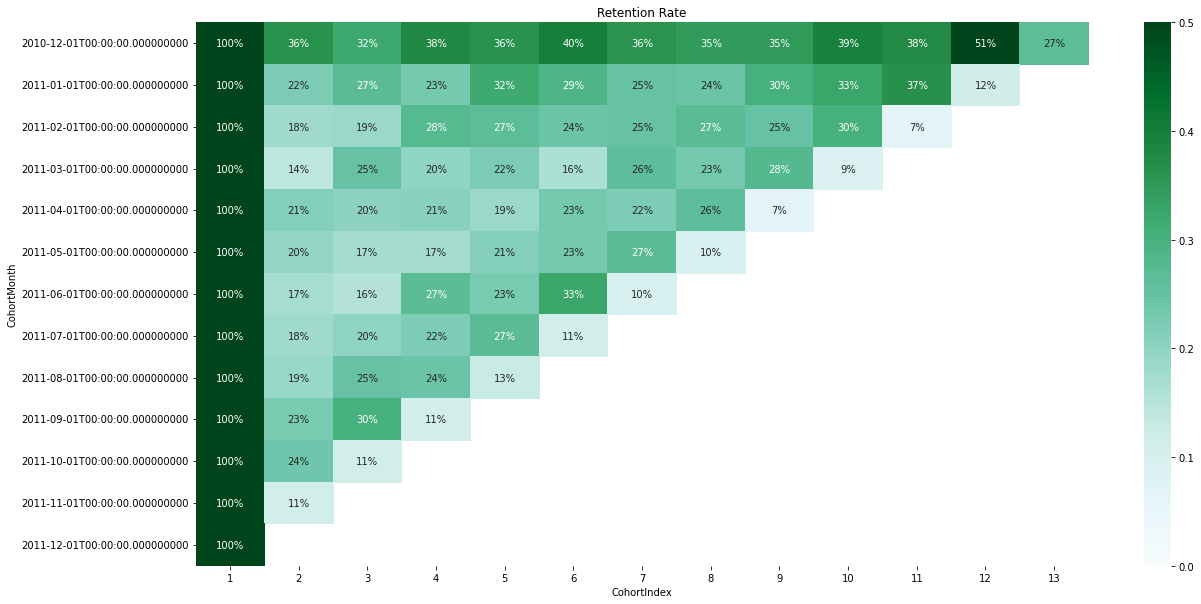

In [317]:
# Heatmap Monthly Recurring Customer percentage
plt.figure(figsize=(20,10))
plt.title("Retention Rate")
sns.heatmap(data=retention,
           annot=True,
           fmt='.0%',
           vmin=0.0,
           vmax=0.5,
           cmap="BuGn")
plt.show()

## Country

In [318]:
# Number of orders
group_country_orders = df.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
group_country_orders.head()

Country
United Kingdom    318737
Germany             7967
France              7377
EIRE                6166
Spain               2136
Name: InvoiceNo, dtype: int64

In [319]:
# Number of orders for different Countries (without UK)
group_country_orders_no_UK = df.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
del group_country_orders_no_UK['United Kingdom']

group_country_orders_no_UK.head()

Country
Germany        7967
France         7377
EIRE           6166
Spain          2136
Netherlands    1912
Name: InvoiceNo, dtype: int64

In [320]:
# Top 5 countries with the fewest orders
group_country_min_orders = df.groupby('Country')['InvoiceNo'].count().sort_values(ascending=True)
del group_country_min_orders['United Kingdom']

group_country_min_orders.head()

Country
Saudi Arabia       9
Bahrain           13
Czech Republic    24
Brazil            25
Lebanon           33
Name: InvoiceNo, dtype: int64

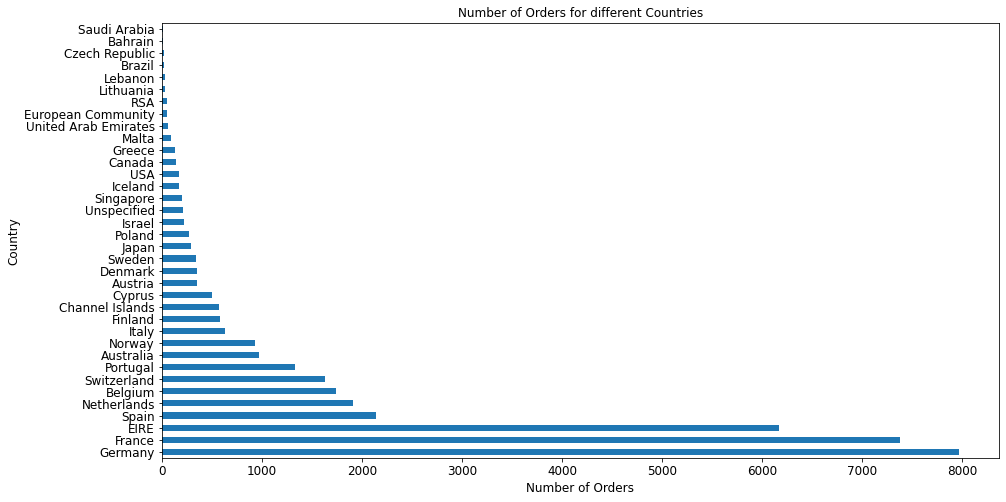

In [321]:
plt.subplots(figsize=(15,8))
group_country_orders_no_UK.plot(kind='barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

In [322]:
# Total money spent by each country
group_country_amount_spent = df.groupby('Country')['AmountSpent'].sum().sort_values(ascending=False).round()
group_country_amount_spent.head()

Country
United Kingdom    5155058.0
Netherlands        180817.0
EIRE               178473.0
Germany            174107.0
France             155396.0
Name: AmountSpent, dtype: float64

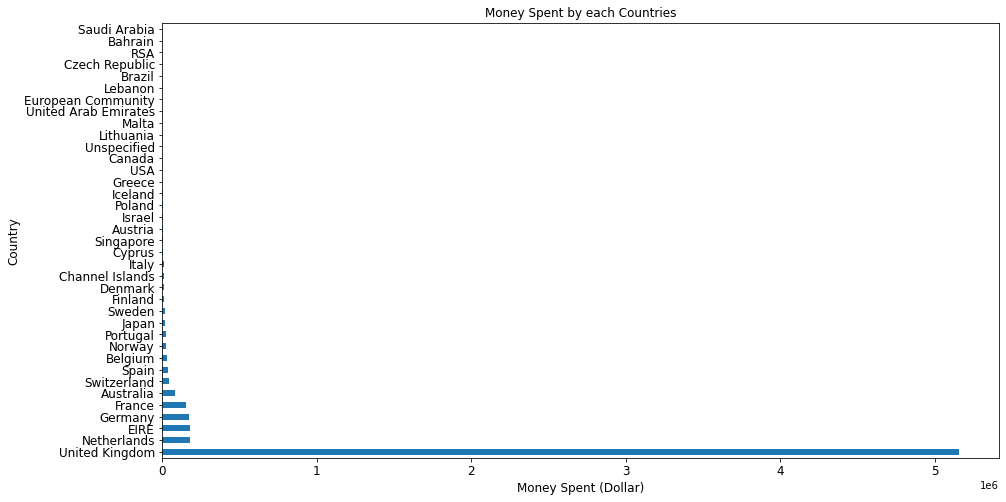

In [323]:
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot(kind='barh', fontsize=12)
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by each Countries', fontsize=12)
plt.show()

In [324]:
# Total money spent by each country (without UK)
group_country_amount_spent_no_UK = df.groupby('Country')['AmountSpent'].sum().sort_values(ascending=False)
del group_country_amount_spent_no_UK['United Kingdom']

group_country_amount_spent_no_UK.head()

Country
Netherlands    180817.22
EIRE           178473.11
Germany        174106.55
France         155395.50
Australia       82859.48
Name: AmountSpent, dtype: float64

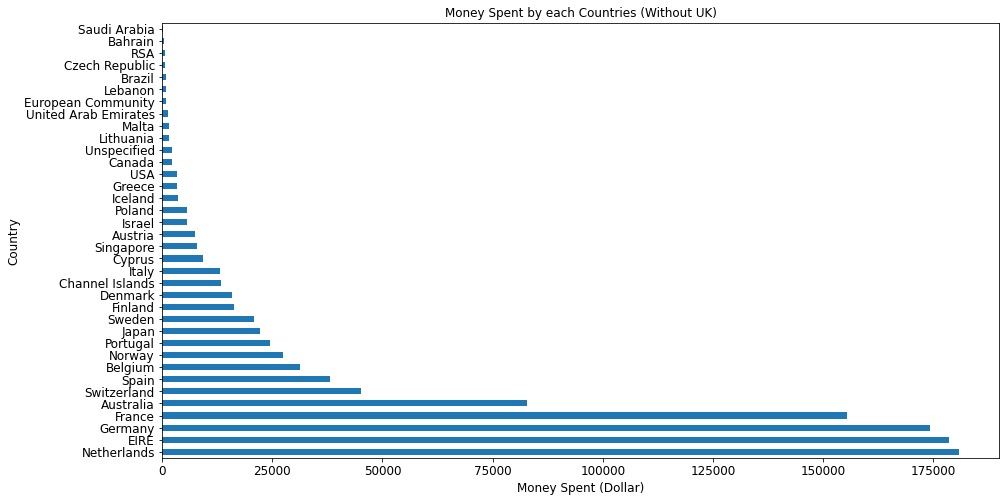

In [325]:
plt.subplots(figsize=(15,8))
group_country_amount_spent_no_UK.plot(kind='barh', fontsize=12)
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by each Countries (Without UK)', fontsize=12)
plt.show()

In [326]:
# Average Country spending
order_country = df.groupby(by=['Country'])['InvoiceNo'].count()
spent_country = df.groupby(by=['Country'])['AmountSpent'].sum()

country_average = spent_country/order_country
country_average.sort_values(ascending=False).head()

Country
Netherlands    94.569676
Australia      85.334171
Japan          76.223174
Sweden         60.720551
Lithuania      47.458857
dtype: float64

In [327]:
# Number of orders made by Nan customers from each Country
nan_cus_ord = df_nan_id.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
nan_cus_ord.head()

Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
Name: InvoiceNo, dtype: int64

In [328]:
# Revenue made by Nan customers from each Country
rev_nan_id = df_nan_id.groupby('Country')['AmountSpent'].sum().sort_values(ascending=False).round()
rev_nan_id.head()

Country
United Kingdom    1419933.0
EIRE                12992.0
Hong Kong           10117.0
Unspecified          2083.0
Israel                914.0
Name: AmountSpent, dtype: float64

In [329]:
# Number of orders of high unit price product
ord_hp = df_high_price.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
ord_hp.head()

Country
United Kingdom    2205
Germany            425
France             347
EIRE               171
Belgium            127
Name: InvoiceNo, dtype: int64

In [330]:
# Revenue of high unit price product
rev_hp = df_high_price.groupby('Country')['AmountSpent'].sum().sort_values(ascending=False).round()
rev_hp.head()

Country
United Kingdom    177378.0
France             26820.0
Germany            24807.0
Singapore          12474.0
EIRE               12166.0
Name: AmountSpent, dtype: float64

## Product

In [331]:
# Special code
special_stockcode = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]
special_stockcode.groupby('StockCode')['Description'].unique()

StockCode
BANK CHARGES                  [Bank Charges]
M                                   [Manual]
PADS            [PADS TO MATCH ALL CUSHIONS]
POST                               [POSTAGE]
Name: Description, dtype: object

In [332]:
# Total special code  
special_count = special_stockcode.groupby('StockCode')['InvoiceNo'].count().sort_values(ascending=False)
special_count

StockCode
M               192
POST             14
PADS              4
BANK CHARGES      1
Name: InvoiceNo, dtype: int64

In [333]:
# Value special code 
special_amount_spent = special_stockcode.groupby('StockCode')['AmountSpent'].sum().sort_values(ascending=False)
special_amount_spent

StockCode
M               1332.640
POST              55.270
PADS               0.003
BANK CHARGES       0.001
Name: AmountSpent, dtype: float64

In [334]:
# Product Quantity
product_count_d = df.groupby('Description')['InvoiceNo'].count().sort_values(ascending=False)
product_count_d

Description
WHITE HANGING HEART T-LIGHT HOLDER    1991
JUMBO BAG RED RETROSPOT               1559
PARTY BUNTING                         1375
ASSORTED COLOUR BIRD ORNAMENT         1342
LUNCH BAG RED RETROSPOT               1299
                                      ... 
LETTER "O" BLING KEY RING                1
BAKING MOULD TOFFEE CUP  CHOCOLATE       1
PINK SMALL GLASS CAKE STAND              1
PINK ROUND COMPACT MIRROR                1
BROCANTE COAT RACK                       1
Name: InvoiceNo, Length: 3616, dtype: int64

In [335]:
# Top 5 StockCode
product_count_s = df.groupby(by=['StockCode','Description'], as_index=False)['InvoiceNo'].count()
product_count_s.sort_values(by='InvoiceNo', ascending=False).head()

,StockCode,Description,InvoiceNo
3257,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1991
3242,85099B,JUMBO BAG RED RETROSPOT,1559
2631,47566,PARTY BUNTING,1375
3087,84879,ASSORTED COLOUR BIRD ORNAMENT,1342
174,20725,LUNCH BAG RED RETROSPOT,1299


In [336]:
product_count_r = df.groupby(by=['StockCode','Description'], as_index=False)['AmountSpent'].sum()
product_count_r.sort_values(by='AmountSpent', ascending=False).head()

,StockCode,Description,AmountSpent
3257,85123A,WHITE HANGING HEART T-LIGHT HOLDER,68071.38
2631,47566,PARTY BUNTING,60978.25
3242,85099B,JUMBO BAG RED RETROSPOT,57201.84
3087,84879,ASSORTED COLOUR BIRD ORNAMENT,37261.43
2790,79321,CHILLI LIGHTS,37255.97


In [337]:
# Revenue By Month of Top 5 Selling Item
df_sc = df[df['StockCode'].isin(['85123A','85099B','47566','84879','20725'])]
df_sc1 = df_sc.groupby([pd.Grouper(key='InvoiceDate', freq='W'),'StockCode'])['AmountSpent'].sum().reset_index().sort_values('InvoiceDate')
df_sc1.sort_values(by='AmountSpent', ascending=False).head()

,InvoiceDate,StockCode,AmountSpent
116,2011-05-22,47566,3101.25
106,2011-05-08,47566,3013.05
161,2011-07-24,47566,2909.00
9,2010-12-12,85123A,2687.15
14,2010-12-19,85123A,2587.80


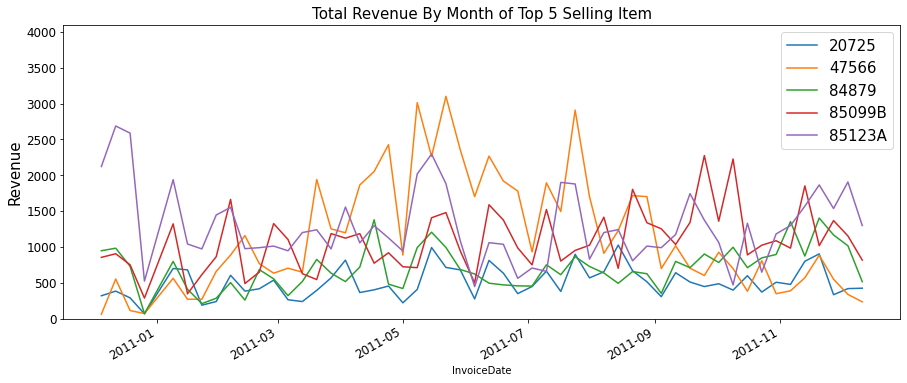

In [338]:
df_sc1.pivot(index="InvoiceDate", columns="StockCode", values="AmountSpent").plot(figsize=(15, 6),fontsize=10)
plt.ylim(0, 4100)
plt.ylabel('Revenue',fontsize=15)
#plt.xlabel('Quantity',fontsize=15)
plt.title('Total Revenue By Month of Top 5 Selling Item',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc=1, prop={'size': 15})
plt.show()
# No meaningful trend for top 5 selling product

In [339]:
# Product UnitPrice 
product_price = df.groupby('Description')['UnitPrice'].sum().sort_values(ascending=False)
product_price

Description
PARTY BUNTING                         6690.900
WHITE HANGING HEART T-LIGHT HOLDER    5763.550
SET OF 3 CAKE TINS PANTRY DESIGN      5601.510
SPOTTY BUNTING                        4957.640
HOME BUILDING BLOCK WORD              4159.350
                                        ...   
PINK FLUFFY CHRISTMAS DECORATION         0.190
CAT WITH SUNGLASSES BLANK CARD           0.190
PADS TO MATCH ALL CUSHIONS               0.003
Bank Charges                             0.001
SET OF 2 TRAYS HOME SWEET HOME           0.000
Name: UnitPrice, Length: 3616, dtype: float64

In [340]:
# Product total spent 
product_amount_spent = df.groupby('Description')['AmountSpent'].sum().sort_values(ascending=False)
product_amount_spent

Description
WHITE HANGING HEART T-LIGHT HOLDER    68071.380
PARTY BUNTING                         60978.250
JUMBO BAG RED RETROSPOT               57201.840
ASSORTED COLOUR BIRD ORNAMENT         37261.430
CHILLI LIGHTS                         37255.970
                                        ...    
SET 12 COLOURING PENCILS DOILEY           0.650
HEN HOUSE W CHICK IN NEST                 0.420
PADS TO MATCH ALL CUSHIONS                0.003
Bank Charges                              0.001
SET OF 2 TRAYS HOME SWEET HOME            0.000
Name: AmountSpent, Length: 3616, dtype: float64

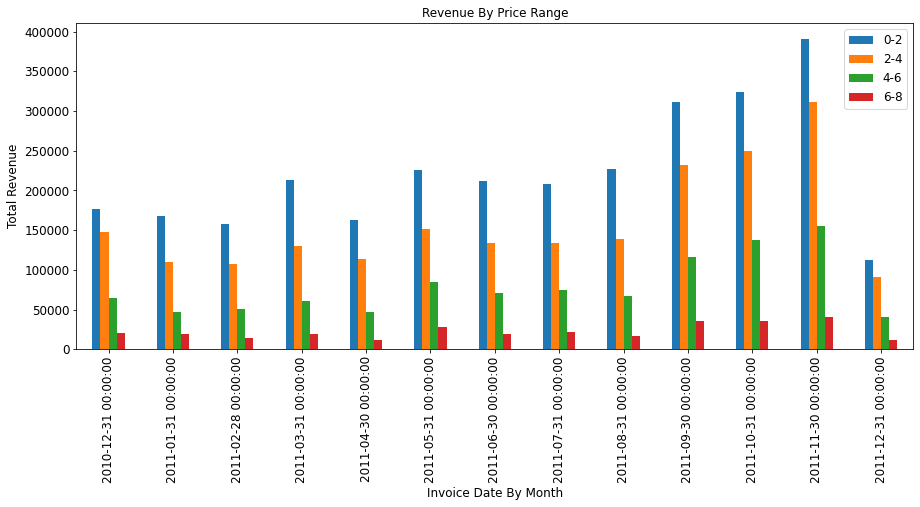

In [341]:
# Revenue By Price Range InvoiceDate
df_range = df[df.PriceRange.isin(['0-2', '2-4', '4-6', '6-8'])]
df_range = df.groupby([pd.Grouper(key='InvoiceDate', freq='M'),'PriceRange'])['AmountSpent'].sum().reset_index().sort_values('InvoiceDate')
df_range.pivot(index="InvoiceDate", columns="PriceRange", values="AmountSpent").plot(kind='bar', figsize=(15, 6), legend=True, fontsize=12)
plt.legend(loc=0, fontsize=12)
plt.title('Revenue By Price Range',fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xlabel('Invoice Date By Month', fontsize=12)
plt.show()
# most of the revenue made from lower unit price of item and high volume of quantity

In [342]:
# Frequent used word in description
df_des = df.Description.str.split(expand=True).stack().value_counts().to_frame().reset_index()
df_des.head(10)
# won't proceed with categorizing product based on the type of words

,index,0
0,OF,38942
1,SET,37110
2,BAG,36904
3,HEART,27897
4,RED,27264
5,RETROSPOT,24036
6,VINTAGE,22719
7,DESIGN,22700
8,PINK,19276
9,CHRISTMAS,17872


In [343]:
# StockCode contain word "Christmast" in the description
df_noel = df[df['Description'].str.contains('christ',case=False, na=False)]
df_noel.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,PriceRange,AmountSpent,CustomerID,Country,InvoiceDate,Year,Month,YearMonth,Season,DayMonth,DayWeek,Hour
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2.55,2-4,204.0,13748.0,United Kingdom,2010-12-01 09:00:00,2010,12,2010-12,1,1,3,9
122,536381,22086,PAPER CHAIN KIT 50'S CHRISTMAS,4,2.95,2-4,11.8,15311.0,United Kingdom,2010-12-01 09:41:00,2010,12,2010-12,1,1,3,9
172,536385,85049A,TRADITIONAL CHRISTMAS RIBBONS,12,1.25,0-2,15.0,17420.0,United Kingdom,2010-12-01 09:56:00,2010,12,2010-12,1,1,3,9
218,536390,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,40,2.55,2-4,102.0,17511.0,United Kingdom,2010-12-01 10:19:00,2010,12,2010-12,1,1,3,10
382,536402,22086,PAPER CHAIN KIT 50'S CHRISTMAS,40,2.55,2-4,102.0,15513.0,United Kingdom,2010-12-01 11:22:00,2010,12,2010-12,1,1,3,11


In [344]:
# AmountSpent of Christmast product 
df_xmas = df_noel.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['AmountSpent'].sum().reset_index().sort_values('InvoiceDate')
df_xmas

,InvoiceDate,AmountSpent
0,2010-12-31,21799.73
1,2011-01-31,352.19
2,2011-02-28,258.41
3,2011-03-31,562.00
4,2011-04-30,295.02
5,2011-05-31,649.37
6,2011-06-30,1351.36
7,2011-07-31,9720.34
8,2011-08-31,15335.58
9,2011-09-30,58966.46


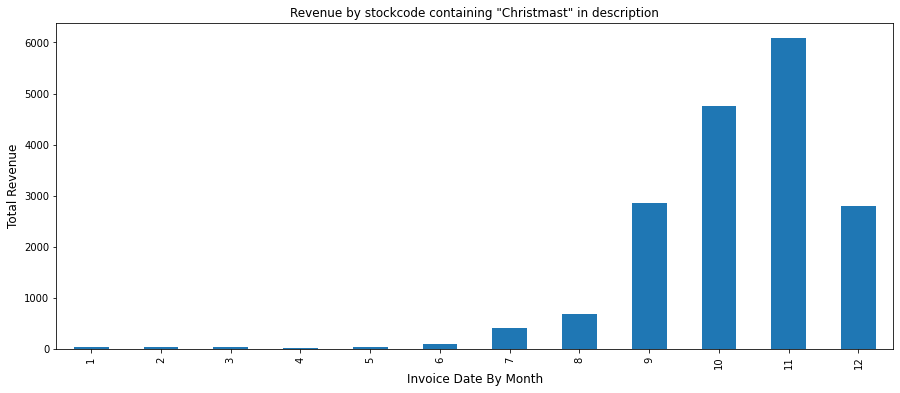

In [345]:
xmas = df_noel.Month.value_counts().sort_index().plot(kind='bar',figsize=(15,6))
xmas.set_xlabel('Invoice Date By Month',fontsize=12)
xmas.set_ylabel('Total Revenue',fontsize=12)
xmas.set_title('Revenue by stockcode containing "Christmast" in description',fontsize=12)
plt.show()

In [346]:
print('Total Orders of Christmast product: ', df_noel['InvoiceNo'].count()) # ~5% of Total
print('Total Revenue of Christmast product: ', df_noel['AmountSpent'].sum().round())

Total Orders of Christmast product:  17873
Total Revenue of Christmast product:  301383.0


In [347]:
# Free Product
df_free = df[df.UnitPrice == 0]
df_free.head()
# Unclear why Free items given to certain customers

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,PriceRange,AmountSpent,CustomerID,Country,InvoiceDate,Year,Month,YearMonth,Season,DayMonth,DayWeek,Hour
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,0.0,NaN,0.0,12647.0,Germany,2010-12-05 14:02:00,2010,12,2010-12,1,5,7,14
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,0.0,NaN,0.0,16560.0,United Kingdom,2010-12-16 14:36:00,2010,12,2010-12,1,16,4,14
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,0.0,NaN,0.0,14911.0,EIRE,2010-12-21 13:45:00,2010,12,2010-12,1,21,2,13
47068,540372,22090,PAPER BUNTING RETROSPOT,24,0.0,NaN,0.0,13081.0,United Kingdom,2011-01-06 16:41:00,2011,1,2011-01,1,6,4,16
47070,540372,22553,PLASTERS IN TIN SKULLS,24,0.0,NaN,0.0,13081.0,United Kingdom,2011-01-06 16:41:00,2011,1,2011-01,1,6,4,16


In [348]:
print('Total Free product given: ', df_free['InvoiceNo'].count()) # ~0.01% of Total

Total Free product given:  36


In [349]:
# Count Free Product by Month
free = df_free.YearMonth.value_counts().sort_index(ascending=False)
free

2011-11    12
2011-10     3
2011-09     2
2011-08     4
2011-07     2
2011-05     2
2011-04     2
2011-03     2
2011-02     1
2011-01     3
2010-12     3
Freq: M, Name: YearMonth, dtype: int64

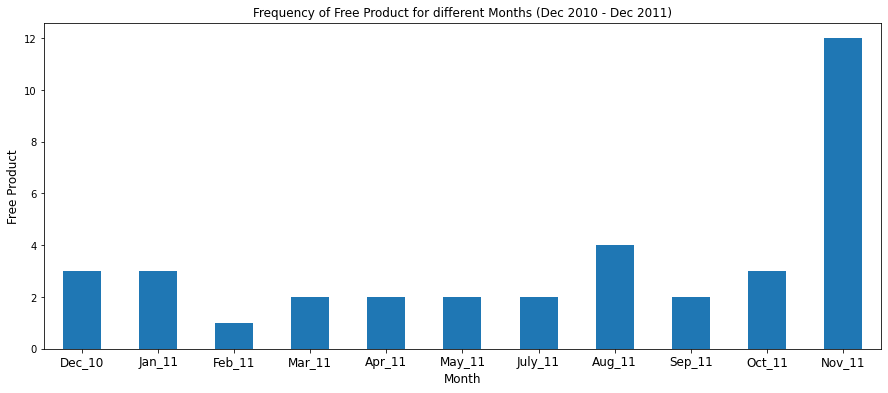

In [350]:
free = df_free.YearMonth.value_counts().sort_index().plot(kind='bar',figsize=(15,6))
free.set_xlabel('Month',fontsize=12)
free.set_ylabel('Free Product',fontsize=12)
free.set_title('Frequency of Free Product for different Months (Dec 2010 - Dec 2011)',fontsize=12)
free.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=12)
plt.show()

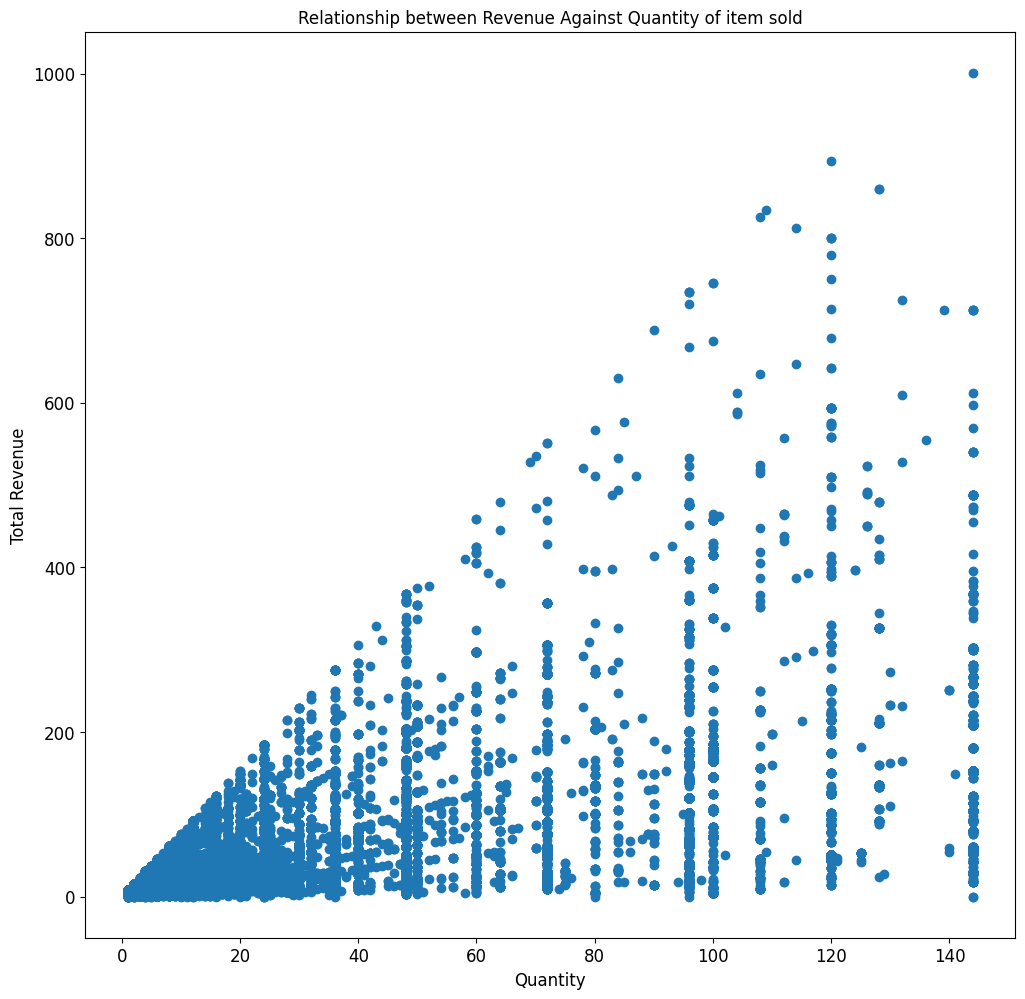

In [351]:
# Relationship between Quantity sold with Revenue
qtt_rev = df[(df['Quantity']<=1000) & (df['AmountSpent']<=2500)]
plt.figure(figsize=(12,12), dpi=100)
plt.scatter(qtt_rev.Quantity, qtt_rev.AmountSpent)
plt.ylabel('Total Revenue',fontsize=12)
plt.xlabel('Quantity',fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Relationship between Revenue Against Quantity of item sold',fontsize=12)
plt.show()
# quantity of item sold conctrated a area around 100

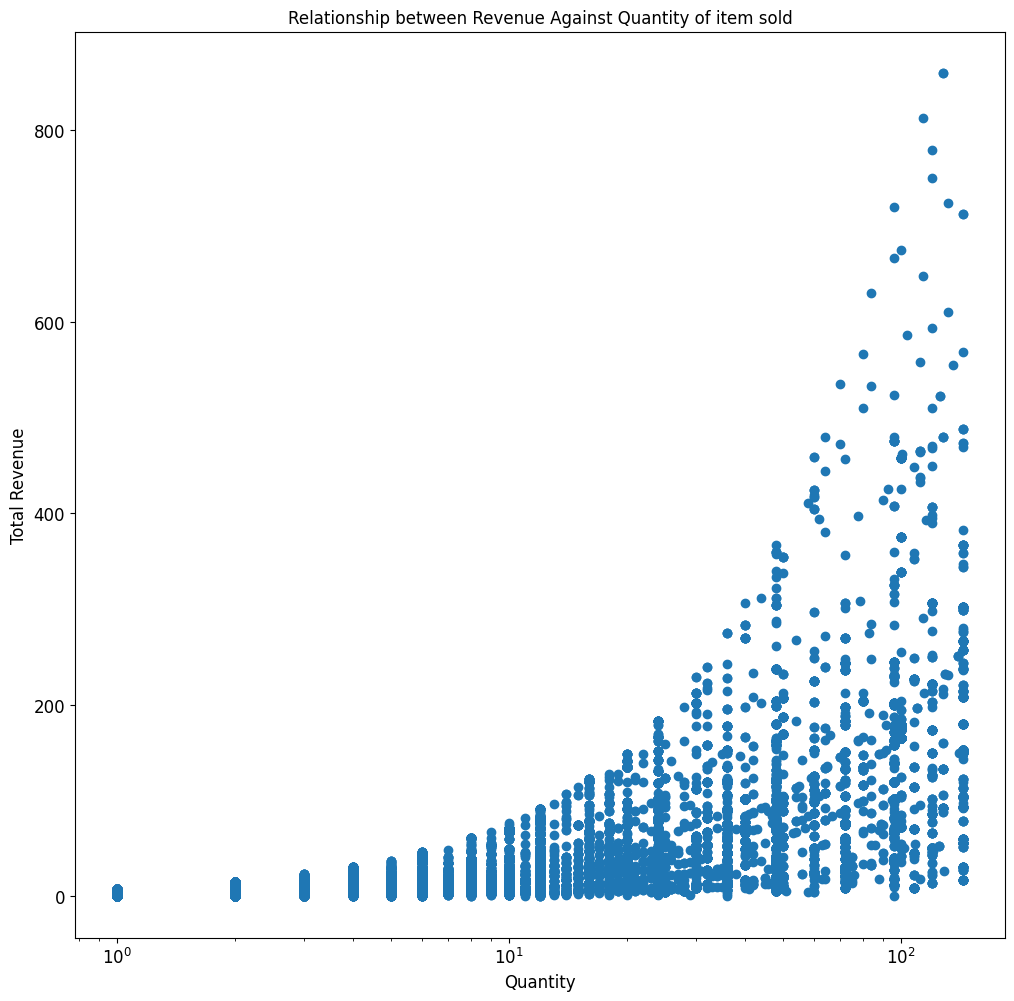

In [352]:
# Remove Special StockCode
remove = ["BANK CHARGES","M","PADS","POST"]
df_remove = df[df.Description.str.contains('|'.join(remove),case=True, na=False)]
df_remove = df_remove[(df_remove["Quantity"]<=1000) & (df_remove["AmountSpent"]<=2500)]
plt.figure(figsize=(12, 12), dpi=100)
plt.scatter(df_remove.Quantity, df_remove.AmountSpent)
plt.xscale('log')
plt.ylabel('Total Revenue',fontsize=12)
plt.xlabel("Quantity",fontsize=12)
plt.title('Relationship between Revenue Against Quantity of item sold',fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
# most of revenue came from quantity between 10-100

## Time

In [353]:
# Number of Orders per Hour
hour = df.groupby('InvoiceNo')['Hour'].unique().value_counts().iloc[:-1].sort_index()
print(hour)

[6]        1
[7]       27
[8]      538
[9]     1332
[10]    2126
[11]    2201
[12]    3004
[13]    2545
[14]    2208
[15]    1983
[16]    1053
[17]     520
[18]     159
[19]     136
[20]      18
Name: Hour, dtype: int64


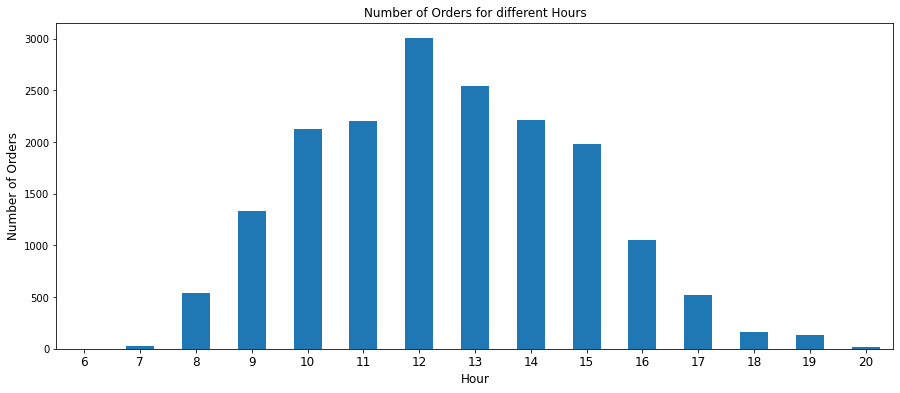

In [354]:
hour = df.groupby('InvoiceNo')['Hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',figsize=(15,6))
hour.set_xlabel('Hour',fontsize=12)
hour.set_ylabel('Number of Orders',fontsize=12)
hour.set_title('Number of Orders for different Hours',fontsize=12)
hour.set_xticklabels(range(6,21), rotation='horizontal', fontsize=12)
plt.show()

In [355]:
# Number of Orders per Weekday
day_week = df.groupby('InvoiceNo')['DayWeek'].unique().value_counts().sort_index()
print(day_week)

[1]    2752
[2]    3057
[3]    3307
[4]    3886
[5]    2714
[7]    2136
Name: DayWeek, dtype: int64


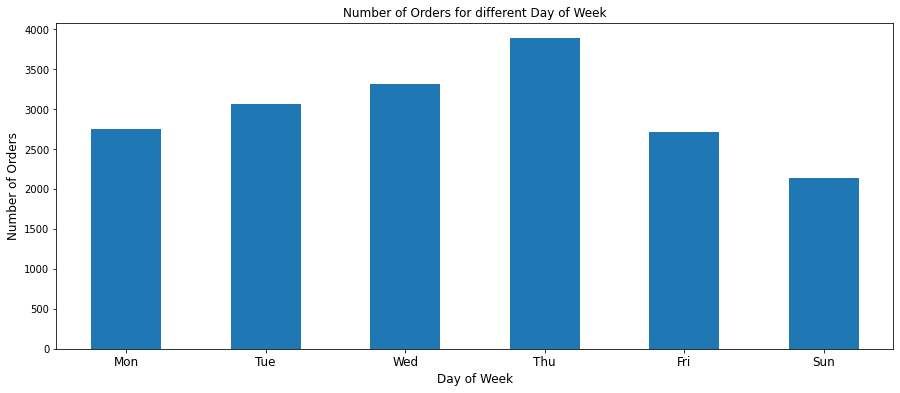

In [356]:
day_week = df.groupby('InvoiceNo')['DayWeek'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))
day_week.set_xlabel('Day of Week',fontsize=12)
day_week.set_ylabel('Number of Orders',fontsize=12)
day_week.set_title('Number of Orders for different Day of Week',fontsize=12)
day_week.set_xticklabels(('Mon','Tue','Wed','Thu','Fri','Sun'), rotation='horizontal', fontsize=12)
plt.show()
# No Order on Saturday, Thursday show the highest number of Orders

In [357]:
# Total Revenue (AmountSpent) by Week 
rev_week = df.groupby(pd.Grouper(key='InvoiceDate', freq='W-MON'))['AmountSpent'].sum().reset_index().sort_values('InvoiceDate')
rev_week.head()

,InvoiceDate,AmountSpent
0,2010-12-06,137313.40
1,2010-12-13,140016.14
2,2010-12-20,113678.01
3,2010-12-27,19106.53
4,2011-01-03,0.00


In [358]:
# Number of Orders per Day of Month
day_month = df.groupby('InvoiceNo')['DayMonth'].unique().value_counts().sort_index()
print(day_month)

[1]     682
[2]     582
[3]     493
[4]     602
[5]     691
[6]     783
[7]     739
[8]     744
[9]     636
[10]    603
[11]    604
[12]    492
[13]    577
[14]    652
[15]    537
[16]    624
[17]    668
[18]    552
[19]    503
[20]    632
[21]    576
[22]    548
[23]    550
[24]    565
[25]    547
[26]    432
[27]    528
[28]    592
[29]    399
[30]    424
[31]    295
Name: DayMonth, dtype: int64


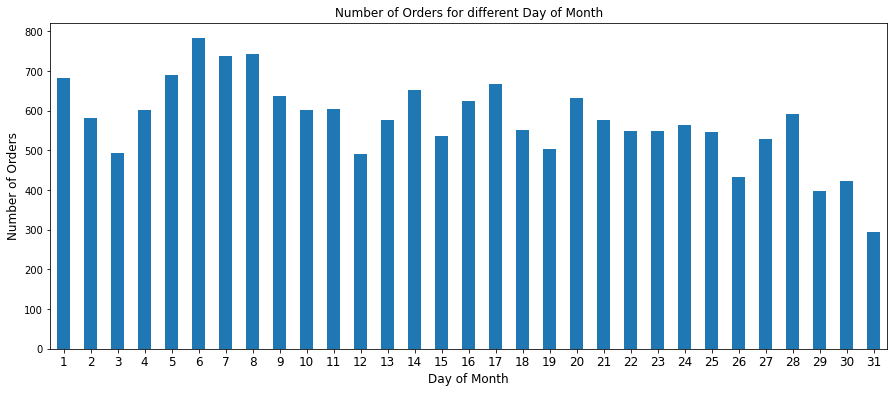

In [359]:
day_month = df.groupby('InvoiceNo')['DayMonth'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))
day_month.set_xlabel('Day of Month',fontsize=12)
day_month.set_ylabel('Number of Orders',fontsize=12)
day_month.set_title('Number of Orders for different Day of Month',fontsize=12)
day_month.set_xticklabels(('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31'), rotation='horizontal', fontsize=12)
plt.show()

In [360]:
# Number of Orders per Month
month = df.groupby('InvoiceNo')['Month'].unique().value_counts().sort_index()
print(month)

[1]      952
[2]      962
[3]     1265
[4]     1097
[5]     1484
[6]     1345
[7]     1286
[8]     1223
[9]     1701
[10]    1851
[11]    2582
[12]    2104
Name: Month, dtype: int64


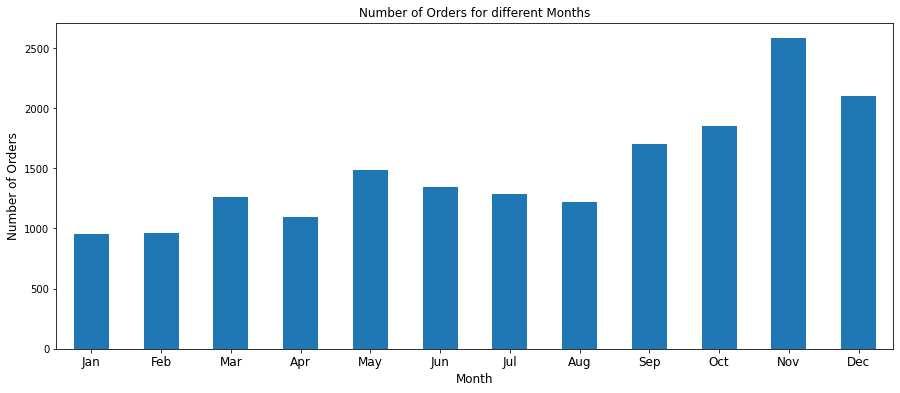

In [361]:
month = df.groupby('InvoiceNo')['Month'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))
month.set_xlabel('Month',fontsize=12)
month.set_ylabel('Number of Orders',fontsize=12)
month.set_title('Number of Orders for different Months',fontsize=12)
month.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'), rotation='horizontal', fontsize=12)
plt.show()

In [362]:
# YearMonth
ym = df['YearMonth'].unique()
ym

<PeriodArray>
['2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
 '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12']
Length: 13, dtype: period[M]

In [363]:
#year_month = df.groupby('InvoiceNo')['YearMonth'].unique().value_counts().sort_index()

In [364]:
# Number of Orders per YearMonth
year_month = df.groupby(by=['YearMonth'], as_index=False)['InvoiceNo'].count()
year_month.sort_values(by='InvoiceNo', ascending=False)

,YearMonth,InvoiceNo
11,2011-11,58394
10,2011-10,44704
9,2011-09,36490
5,2011-05,24883
8,2011-08,24273
7,2011-07,24219
6,2011-06,24045
3,2011-03,24007
0,2010-12,23259
4,2011-04,20065


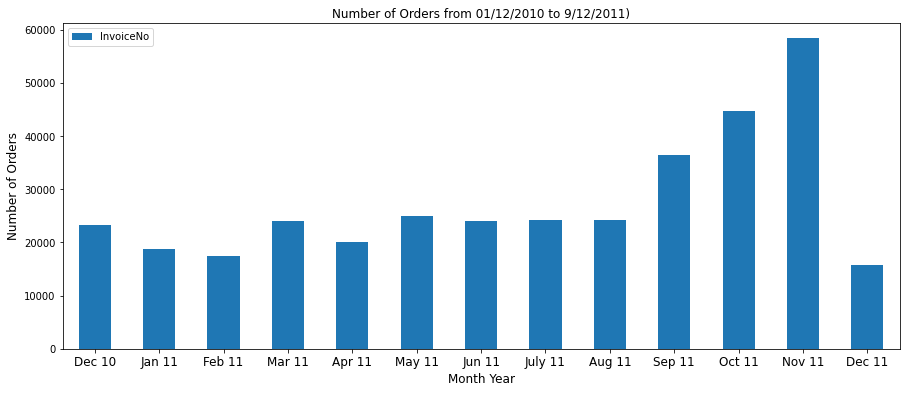

In [365]:
year_month = df.groupby(by=['YearMonth'], as_index=False)['InvoiceNo'].count().plot(kind='bar',figsize=(15,6))
year_month.set_xlabel('Month Year',fontsize=12)
year_month.set_ylabel('Number of Orders',fontsize=12)
year_month.set_title('Number of Orders from 01/12/2010 to 9/12/2011)',fontsize=12)
year_month.set_xticklabels(('Dec 10','Jan 11','Feb 11','Mar 11','Apr 11','May 11','Jun 11','July 11','Aug 11','Sep 11','Oct 11','Nov 11','Dec 11'), rotation='horizontal', fontsize=12)
plt.show()

In [366]:
# Total Revenue (AmountSpent) by Months 
df.groupby(df['InvoiceDate'].dt.strftime('%B %Y'))['AmountSpent'].sum().sort_values(ascending=False)

InvoiceDate
November 2011     898242.720
October 2011      747611.850
September 2011    695763.752
May 2011          490759.230
August 2011       449540.840
July 2011         437997.531
June 2011         435778.840
March 2011        423642.550
December 2010     410114.080
January 2011      345195.940
April 2011        334466.901
February 2011     330040.780
December 2011     256518.330
Name: AmountSpent, dtype: float64

In [367]:
# Number of Orders per Year
year = df.groupby('InvoiceNo')['Year'].unique().value_counts().sort_index()
print(year)

[2010]     1349
[2011]    16503
Name: Year, dtype: int64


In [368]:
# Total Revenue (AmountSpent) through out the year
df.AmountSpent.sum()

6255673.3440000005

In [369]:
# Number of Orders per Season, which 1='Winter', 2='Spring', 3='Summer', 4='Autumn'
season_orders = df.groupby('Season')['InvoiceNo'].count().sort_values(ascending=False)
season_orders.head()

Season
4    139588
1     75348
3     72537
2     68955
Name: InvoiceNo, dtype: int64

In [370]:
# Total Revenue (AmountSpent) per Season
df.groupby(df['Season'])['AmountSpent'].sum().sort_values(ascending=False)

Season
4    2341618.322
1    1341869.130
3    1323317.211
2    1248868.681
Name: AmountSpent, dtype: float64

## Canceled Orders

In [371]:
# Customers with the most canceled orders
cus_max_cancel = df_cancel.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()
cus_max_cancel.sort_values(by='InvoiceNo', ascending=False).head()

,CustomerID,Country,InvoiceNo
737,14911.0,EIRE,226
1486,17841.0,United Kingdom,136
1398,17511.0,United Kingdom,113
849,15311.0,United Kingdom,112
90,12607.0,USA,101


In [372]:
# Customer's Amount Canceled
money_cancel = df_cancel.groupby(by=['CustomerID','Country'], as_index=True)['AmountSpent'].sum()
money_cancel.head()

CustomerID  Country       
12346.0     United Kingdom   -77183.60
12352.0     Norway             -960.63
12359.0     Cyprus             -127.05
12362.0     Belgium             -71.65
12365.0     Cyprus             -320.69
Name: AmountSpent, dtype: float64

In [373]:
# Total number of canceled orders by country
country_order_cancel = df_cancel.groupby(by=['Country'], as_index=False)['InvoiceNo'].count()
country_order_cancel.sort_values(by='InvoiceNo', ascending=False).head()

,Country,InvoiceNo
29,United Kingdom,7856
12,Germany,453
8,EIRE,302
11,France,149
28,USA,112


In [374]:
# Total amount canceled by country
group_country_amount_cancel = df_cancel.groupby('Country')['AmountSpent'].sum().sort_values(ascending=True)
group_country_amount_cancel.head()

Country
United Kingdom   -815291.60
EIRE              -20177.14
France            -12311.21
Singapore         -12158.90
Germany            -7168.93
Name: AmountSpent, dtype: float64

In [375]:
# Number of canceled orders per Hour
hour_c = df_cancel.groupby('InvoiceNo')['Hour'].unique().value_counts().sort_index()
print(hour_c)

[6]      21
[7]       2
[8]      54
[9]     234
[10]    397
[11]    523
[12]    498
[13]    430
[14]    400
[15]    401
[16]    400
[17]    304
[18]     89
[19]     73
[20]     10
Name: Hour, dtype: int64


In [376]:
# Number of canceled orders per Day of Week
weekday_c = df_cancel.groupby('InvoiceNo')['DayWeek'].unique().value_counts().sort_index()
print(weekday_c)

[1]    718
[2]    749
[3]    673
[4]    971
[5]    551
[7]    174
Name: DayWeek, dtype: int64


In [377]:
# Number of canceled orders per Day of Month
monthday_c = df_cancel.groupby('InvoiceNo')['DayMonth'].unique().value_counts().sort_index()
print(monthday_c)

[1]     145
[2]     134
[3]      94
[4]     117
[5]     102
[6]     193
[7]     157
[8]     141
[9]     120
[10]    181
[11]    147
[12]    104
[13]    105
[14]    187
[15]    112
[16]    100
[17]    128
[18]    172
[19]    109
[20]    137
[21]    173
[22]     81
[23]    118
[24]    143
[25]     78
[26]     80
[27]    127
[28]    122
[29]     48
[30]     83
[31]     98
Name: DayMonth, dtype: int64


In [378]:
# Number of canceled orders per Month
month_c = df_cancel.groupby('InvoiceNo')['Month'].unique().value_counts().sort_index()
print(month_c)

[1]     260
[2]     219
[3]     318
[4]     240
[5]     314
[6]     329
[7]     270
[8]     278
[9]     333
[10]    362
[11]    441
[12]    472
Name: Month, dtype: int64


In [379]:
# Number of canceled orders per Year
year_c = df_cancel.groupby('InvoiceNo')['Year'].unique().value_counts().sort_index()
print(year_c)

[2010]     326
[2011]    3510
Name: Year, dtype: int64


In [380]:
# Number of canceled orders per YearMonth
year_month_c = df_cancel.groupby(by=['YearMonth'], as_index=False)['InvoiceNo'].count()
year_month_c.sort_values(by='InvoiceNo', ascending=False)

,YearMonth,InvoiceNo
10,2011-10,1200
11,2011-11,1076
9,2011-09,805
0,2010-12,728
6,2011-06,711
1,2011-01,701
3,2011-03,699
7,2011-07,685
8,2011-08,668
5,2011-05,621


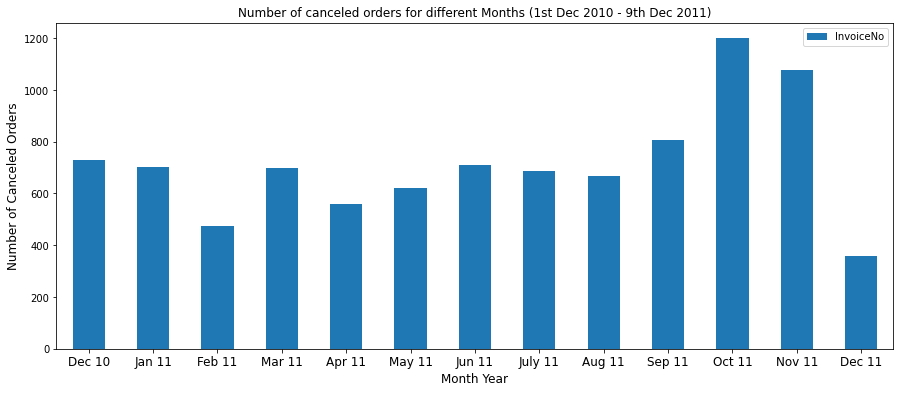

In [381]:
year_month_c = df_cancel.groupby(by=['YearMonth'], as_index=False)['InvoiceNo'].count().plot(kind='bar',figsize=(15,6))
year_month_c.set_xlabel('Month Year',fontsize=12)
year_month_c.set_ylabel('Number of Canceled Orders',fontsize=12)
year_month_c.set_title('Number of canceled orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=12)
year_month_c.set_xticklabels(('Dec 10','Jan 11','Feb 11','Mar 11','Apr 11','May 11','Jun 11','July 11','Aug 11','Sep 11','Oct 11','Nov 11','Dec 11'), rotation='horizontal', fontsize=12)
plt.show()

# DATA MODELLING